# Skelton Notebook Converting EOPF Zarr format in UTM to HEALPix 
We use EOPF Sample service data here. 
This workflow can be applied to any UTM expressed EOPF ZARR format. 

## Install dependencies — HEALPix indexing/operations

- Installs required Python packages for this notebook. Uses HEALPix to index or transform gridded Earth data.


In [1]:
!pip install xarray-eopf foscat xdggs healpix-geo

<!-- auto-md: healpix_zarr_dask -->
### Imports and setup

- Loads libraries: matplotlib, numpy, xarray. Configures plotting options.


In [2]:
import xarray as xr
import pystac_client
import matplotlib.pyplot as plt
import numpy as np
import pyproj


### Open datasets with Xarray 


- Opens datasets using Xarray (lazy loading with Dask if chunked).


In [3]:
# Access cloud-optimized Sentinel-2 data via the EOPF STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Define oceanographic study area and time window
LON, LAT = -4.5, 48  # Bay of Biscay - known for consistent wave patterns
date = "2025-06-17/2025-06-17"

# Search criteria optimized for wave analysis
collections = ["sentinel-2-l1c"]
items = list(
    catalog.search(
        datetime=date,
        collections=collections,
        intersects=dict(type="Point", coordinates=[LON, LAT]),
        query={
            "eo:cloud_cover": {
                "lt": 20
            },  # Cloud cover < 20% ensures clear ocean surface
            "view:sun_elevation": {
                "gt": 25
            },  # Filter for high sun elevation > 25° (→ sun zenith angle < 65°),
            # which places the sun near the zenith.
        },
    ).items()
)

for item in items:
    print(f"✅ {item.id}")

item = items[0]

# Open the dataset lazily from object storage
dt = xr.open_datatree(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)

dt

✅ S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


<xarray.DataTree>
Group: /
│   Attributes: (3)
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 23, x: 23,
│   │                                           detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 56B 3 4 5 6 7 8 9
│   │         * x                              (x) int64 184B 300000 305000 ... 410000
│   │         * y                              (y) int64 184B 5400000 5395000 ... 5290000
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (band, angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
│   │           sun_angles                     (angle, y, x) float64 8kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
│   │           viewing_incidence_angles       (band, detector, angle, y, x) float64 770kB dask.array<chunksize=(7, 4, 2, 23, 23), meta=np.ndarray>
│   ├── Group: /conditions/mask
│   │   ├── Group: /conditions/mask/detector_footprint
│   │   │   ├── Group: /conditions/mask/detector_footprint/r10m
│   │   │   │       Dimensions:  (y: 10980, x: 10980)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
│   │   │   │         * y        (y) int64 88kB 5399995 5399985 5399975 ... 5290225 5290215 5290205
│   │   │   │       Data variables:
│   │   │   │           b02      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b03      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b04      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b08      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   ├── Group: /conditions/mask/detector_footprint/r20m
│   │   │   │       Dimensions:  (y: 5490, x: 5490)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 44kB 300010 300030 300050 300070 ... 409750 409770 409790
│   │   │   │         * y        (y) int64 44kB 5399990 5399970 5399950 ... 5290250 5290230 5290210
│   │   │   │       Data variables:
│   │   │   │           b05      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b06      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b07      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b11      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b12      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b8a      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   └── Group: /conditions/mask/detector_footprint/r60m
│   │   │           Dimensions:  (y: 1830, x: 1830)
│   │   │           Coordinates:
│   │   │             * x        (x) int64 15kB 300030 300090 300150 300210 ... 409650 409710 409770
│   │   │             * y        (y) int64 15kB 5399970 5399910 5399850 ... 5290350 5290290 5290230
│   │   │           Data variables:
│   │   │               b01      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b09      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b10      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   └── Group: /conditions/mask/l1c_classification
│   │       └── Group: /conditions/mask/l1c_classification/r60m
│   │               Dimensions:  (y: 1830, x: 18

In [4]:
#chose small area in UTM 
## TODO, we can update here to chose  'one detection' area. 

small_dt=dt.sel(
    x=slice(dt['conditions']['geometry']['sun_angles'].x[0],dt['conditions']['geometry']['sun_angles'].x[2]),
    y=slice(dt['conditions']['geometry']['sun_angles'].y[-3],dt['conditions']['geometry']['sun_angles'].y[-1]),
)

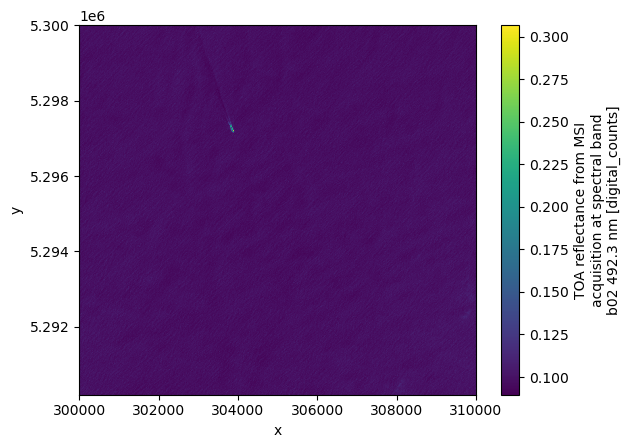

In [5]:
# We see , probably a boat.
# Todo, add plot for small_dt['conditions']['l1c_quicklook']['r10m']
#small_dt['conditions']['l1c_quicklook']['r10m'].hvplot.rgb(x='x',y='y', )

small_dt["measurements"]["reflectance"]["r10m"]["b02"].plot()

### Annotate UTM with latitude and Longitude 


In [6]:
def _add_latlon(ds: xr.Dataset, transformer: pyproj.Transformer) -> xr.Dataset:
    """Attach latitude/longitude coords + CF metadata to a Dataset with (x,y)."""
    if not {"x", "y"}.issubset(ds.dims):
        return ds

    xx, yy = np.meshgrid(ds["x"].values, ds["y"].values, indexing="xy")
    lon, lat = transformer.transform(xx, yy)

    ds = ds.assign_coords(
        longitude=(("y", "x"), lon),
        latitude=(("y", "x"), lat),
    )
    ds["latitude"].attrs.update({
        "standard_name": "latitude",
        "long_name": "Latitude",
        "units": "degrees_north",
        "axis": "Y",
    })
    ds["longitude"].attrs.update({
        "standard_name": "longitude",
        "long_name": "Longitude",
        "units": "degrees_east",
        "axis": "X",
    })

    # Make sure vars with (y,x) advertise the aux coords
    for var in ds.data_vars:
        if {"y", "x"}.issubset(ds[var].dims):
            existing = ds[var].attrs.get("coordinates", "").split()
            ds[var].attrs["coordinates"] = " ".join(
                sorted(set(existing) | {"latitude", "longitude"})
            )
    return ds


def add_latlon(path: str, ds: xr.Dataset, transformer: pyproj.Transformer) -> xr.Dataset:
    """Wrapper for safe application on a node dataset."""
    if ds is None:
        print(path, "no dataset")
        return ds
    if not {"x", "y"}.issubset(ds.dims):
        print(path, "not both x,y")
        return ds
    return _add_latlon(ds, transformer)


def add_latlon_to_dt(dt: xr.DataTree) -> xr.DataTree:
    """Return a new DataTree with latitude/longitude coords added everywhere possible."""
    crs_code = dt.attrs["other_metadata"]["horizontal_CRS_code"]
    src_crs = pyproj.CRS.from_string(crs_code)
    transformer = pyproj.Transformer.from_crs(
        src_crs, pyproj.CRS.from_epsg(4326), always_xy=True
    )
    return xr.DataTree.from_dict(
        {path: add_latlon(path, node.ds, transformer) for path, node in dt.subtree_with_keys}
    )

In [7]:
%%time
latlon_dt=add_latlon_to_dt(small_dt)

. not both x,y
conditions not both x,y
measurements not both x,y
quality not both x,y
conditions/mask not both x,y
conditions/meteorology not both x,y
measurements/reflectance not both x,y
quality/l1c_quicklook not both x,y
quality/mask not both x,y
conditions/mask/detector_footprint not both x,y
conditions/mask/l1c_classification not both x,y
conditions/meteorology/cams not both x,y
conditions/meteorology/ecmwf not both x,y
CPU times: user 748 ms, sys: 15.1 ms, total: 763 ms
Wall time: 761 ms


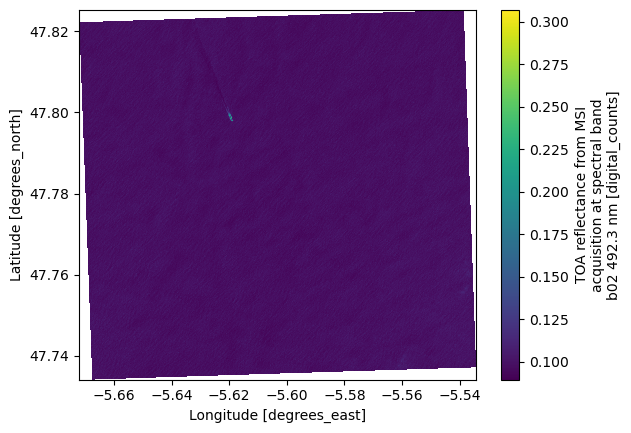

In [8]:

latlon_dt["measurements"]["reflectance"]["r10m"]["b02"].plot(x='longitude',y='latitude')



In [9]:
#Update to Authalic 
#todo, ask JM/Justus to check
# todo, if this function already exist in healpix_geo, call that function


# ---- WGS84 constants ----
a = 6378137.0
f = 1/298.257223563
e2 = 2*f - f*f
e  = np.sqrt(e2)

# ---- one packed NumPy function (array-in, array-out) ----
def _authalic_beta_numpy(lat_deg: np.ndarray) -> np.ndarray:
    lat = np.deg2rad(lat_deg)

    # avoid log(0) at exact poles
    s = np.sin(lat)
    s = np.clip(s, -1.0 + 1e-15, 1.0 - 1e-15)

    one_minus_e2 = 1.0 - e2
    q  = one_minus_e2 * (
        (s / (1.0 - e2*s*s))
        - (1.0/(2.0*e)) * np.log((1.0 - e*s)/(1.0 + e*s))
    )
    qp = 1.0 - one_minus_e2/(2.0*e) * np.log((1.0 - e)/(1.0 + e))

    ratio = np.clip(q/qp, -1.0, 1.0)
    beta  = np.arcsin(ratio)

    # keep exact poles unchanged (β = φ)
    beta = np.where(np.isclose(np.abs(lat), np.pi/2), lat, beta)

    return np.rad2deg(beta)

# Optional thin wrapper (keeps your original name)
def update_latitude_to_authalic(lat_da: xr.DataArray) -> xr.DataArray:
    # Single apply_ufunc call; no vectorization loops, no dask parallelization.
    beta = xr.apply_ufunc(
        _authalic_beta_numpy,
        lat_da,
        vectorize=False,  # pass whole ndarray to our packed NumPy function
        dask=None,        # avoid dask-specific behavior
        keep_attrs=True,
    )
    return beta

# If you prefer to avoid apply_ufunc entirely (loads coord into memory):
# def update_latitude_to_authalic(lat_da: xr.DataArray) -> xr.DataArray:
#     data = _authalic_beta_numpy(np.asarray(lat_da))
#     return xr.DataArray(data, coords=lat_da.coords, dims=lat_da.dims, attrs=lat_da.attrs)

def _swich_to_authalic(ds: xr.Dataset) -> xr.Dataset:
    if ds is None:
        return ds
    if not (("latitude" in ds.coords) and ("longitude" in ds.coords)):
        return ds

    lat_auth = update_latitude_to_authalic(ds["latitude"])
    ds = ds.assign_coords(latitude=lat_auth)

    ds["latitude"].attrs.update({
        "standard_name": "authalic_latitude",   # note: not a CF standard_name
        "long_name": "Authalic Latitude",
        "units": "degrees_north",
        "axis": "Y",
        "comment": "Converted from WGS84 geodetic latitude to authalic latitude (equal-area sphere).",
    })
    ds["longitude"].attrs.setdefault("units", "degrees_east")
    ds["longitude"].attrs.setdefault("axis", "X")
    return ds

def _switch_to_authalic(ds: xr.Dataset) -> xr.Dataset:
    return _swich_to_authalic(ds)

def swich_to_authalic(path: str, ds: xr.Dataset) -> xr.Dataset:
    if ds is None:
        print(path, "no dataset")
        return ds
    if not (("latitude" in ds.coords) and ("longitude" in ds.coords)):
        print(path, "not both lat,lon")
        return ds
    return _swich_to_authalic(ds)

def add_latlon_to_dt(dt: "xr.DataTree") -> "xr.DataTree":
    mapping = {path: swich_to_authalic(path, node.ds) for path, node in dt.subtree_with_keys}
    return xr.DataTree.from_dict(mapping)

def authalic(dt: "xr.DataTree") -> "xr.DataTree":
    return add_latlon_to_dt(dt)

authalic_dt=authalic(latlon_dt)  
authalic_dt

. not both lat,lon
conditions not both lat,lon
measurements not both lat,lon
quality not both lat,lon
conditions/mask not both lat,lon
conditions/meteorology not both lat,lon
measurements/reflectance not both lat,lon
quality/l1c_quicklook not both lat,lon
quality/mask not both lat,lon
conditions/mask/detector_footprint not both lat,lon
conditions/mask/l1c_classification not both lat,lon


<xarray.DataTree>
Group: /
│   Attributes: (3)
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 3, x: 3, detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 56B 3 4 5 6 7 8 9
│   │         * x                              (x) int64 24B 300000 305000 310000
│   │         * y                              (y) int64 24B 5300000 5295000 5290000
│   │           longitude                      (y, x) float64 72B -5.672 -5.605 ... -5.534
│   │           latitude                       (y, x) float64 72B 47.69 47.7 ... 47.61 47.61
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (band, angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
│   │           sun_angles                     (angle, y, x) float64 144B dask.array<chunksize=(2, 3, 3), meta=np.ndarray>
│   │           viewing_incidence_angles       (band, detector, angle, y, x) float64 13kB dask.array<chunksize=(7, 4, 2, 3, 3), meta=np.ndarray>
│   ├── Group: /conditions/mask
│   │   ├── Group: /conditions/mask/detector_footprint
│   │   │   ├── Group: /conditions/mask/detector_footprint/r10m
│   │   │   │       Dimensions:    (y: 980, x: 1000)
│   │   │   │       Coordinates:
│   │   │   │         * x          (x) int64 8kB 300005 300015 300025 ... 309975 309985 309995
│   │   │   │         * y          (y) int64 8kB 5299995 5299985 5299975 ... 5290225 5290215 5290205
│   │   │   │           longitude  (y, x) float64 8MB -5.672 -5.672 -5.672 ... -5.535 -5.535 -5.534
│   │   │   │           latitude   (y, x) float64 8MB 47.69 47.69 47.69 47.69 ... 47.61 47.61 47.61
│   │   │   │       Data variables:
│   │   │   │           b02        (y, x) uint8 980kB dask.array<chunksize=(980, 1000), meta=np.ndarray>
│   │   │   │           b03        (y, x) uint8 980kB dask.array<chunksize=(980, 1000), meta=np.ndarray>
│   │   │   │           b04        (y, x) uint8 980kB dask.array<chunksize=(980, 1000), meta=np.ndarray>
│   │   │   │           b08        (y, x) uint8 980kB dask.array<chunksize=(980, 1000), meta=np.ndarray>
│   │   │   ├── Group: /conditions/mask/detector_footprint/r20m
│   │   │   │       Dimensions:    (y: 490, x: 500)
│   │   │   │       Coordinates:
│   │   │   │         * x          (x) int64 4kB 300010 300030 300050 ... 309950 309970 309990
│   │   │   │         * y          (y) int64 4kB 5299990 5299970 5299950 ... 5290250 5290230 5290210
│   │   │   │           longitude  (y, x) float64 2MB -5.672 -5.672 -5.671 ... -5.535 -5.535 -5.534
│   │   │   │           latitude   (y, x) float64 2MB 47.69 47.69 47.69 47.69 ... 47.61 47.61 47.61
│   │   │   │       Data variables:
│   │   │   │           b05        (y, x) uint8 245kB dask.array<chunksize=(490, 500), meta=np.ndarray>
│   │   │   │           b06        (y, x) uint8 245kB dask.array<chunksize=(490, 500), meta=np.ndarray>
│   │   │   │           b07        (y, x) uint8 245kB dask.array<chunksize=(490, 500), meta=np.ndarray>
│   │   │   │           b11        (y, x) uint8 245kB dask.array<chunksize=(490, 500), meta=np.ndarray>
│   │   │   │           b12        (y, x) uint8 245kB dask.array<chunksize=(490, 500), meta=np.ndarray>
│   │   │   │           b8a        (y, x) uint8 245kB dask.array<chunksize=(490, 500), meta=np.ndarray>
│   │   │   └── Group: /conditions/mask/detector_footprint/r60m
│   │   │           Dimensions:    (y: 163, x: 167)
│   │   │           Coordinates:
│   │   │             * x          (x) int64 1kB 300030 300090 300150 ... 309870 309930 309990
│   │   │             * y          (y) int64 1kB 5299950 5299890 5299830 ... 5290350 5290290 5290230
│  

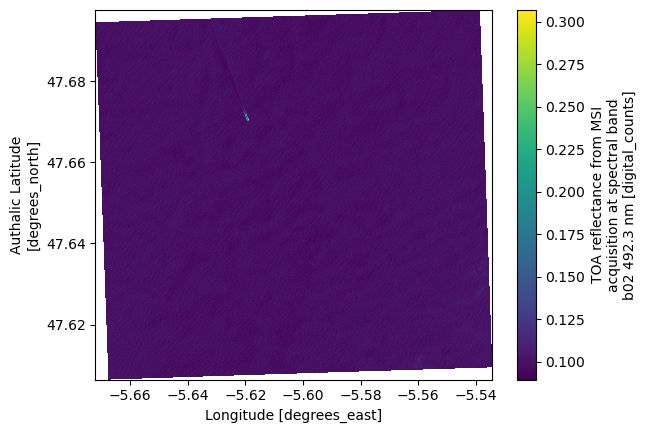

In [10]:
authalic_dt["measurements"]["reflectance"]["r10m"]["b02"].plot(x='longitude',y='latitude')

#todo : plot quicklook
#authalic_dt['conditions']['l1c_quicklook']['r10m'].hvplot.rgb(x='x',y='y', )



In [11]:
#Conversion to HEALPix.
# Todo here: add 'data_tree' branch that indicate 'Healpix_level', i.e. instead of r10m, 
# we use 19, or level_19 or something which does pyramidal.
# but this nomination r10m, it is comming from where? L1B?? 




from healpix_geo.nested import lonlat_to_healpix

# --- level selection (coarsest grid not finer than dx) ---
EARTH_RADIUS_M = 6_371_000.0  # radius used in healpix-geo levels table

def _healpix_edge_length_m(level: int, radius_m: float = EARTH_RADIUS_M) -> float:
    # edge = R * sqrt(pi/3) / 2**level  (matches healpix-geo "levels" page)
    return radius_m * np.sqrt(np.pi / 3.0) / (2 ** level)

def _infer_dx_from_x(ds: xr.Dataset) -> float:
    x = np.asarray(ds["x"].values)
    dx = float(np.nanmedian(np.abs(np.diff(x))))
    if not np.isfinite(dx) or dx <= 0:
        raise ValueError("Could not infer a positive spacing from ds['x'].")
    return dx

def choose_healpix_level_from_dx(ds: xr.Dataset,
                                 min_level: int = 0,
                                 max_level: int = 29) -> int:
    dx = _infer_dx_from_x(ds)
    base = EARTH_RADIUS_M * np.sqrt(np.pi / 3.0)
    level = int(np.floor(np.log2(base / dx)))   # edge(level) >= dx
    return int(np.clip(level, min_level, max_level))

# --- single-dataset transform -> grouped by unique HEALPix cell_ids ---
def to_healpix_cells_grouped_mean(ds: xr.Dataset,
                                  level: int | None = None,
                                  ellipsoid: str = "WGS84") -> xr.Dataset:
    """
    Returns a dataset with dims (angle, cell_ids), where 'cell_ids' is a
    dimension/coordinate containing unique HEALPix ids (NESTED).
    Values are averaged over all source samples that mapped to the same cell.
    """
    if not {"y", "x"}.issubset(ds.dims):
        raise ValueError("Dataset must have 'y' and 'x' dimensions.")
    if not {"latitude", "longitude"}.issubset(ds.coords):
        raise ValueError("Dataset must have 'latitude' and 'longitude' coords (degrees).")

    if level is None:
        level = choose_healpix_level_from_dx(ds)

    # 1) hash each (lon,lat) to HEALPix nested cell id
    lon = ds["longitude"].values.ravel()
    lat = ds["latitude"].values.ravel()
    cell_ids = lonlat_to_healpix(lon, lat, level, ellipsoid=ellipsoid)

    # 2) stack (y,x) -> cells
    out = ds.stack(cells=("y", "x"))

    # 3) attach cell_ids coord on 'cells'
    out = out.assign_coords(cell_ids=("cells", cell_ids.astype("int64")))
    out["cell_ids"].attrs.update({
        "grid_name": "healpix",
        "level": level,
        "indexing_scheme": "nested",
    })
    cell_ids_attrs = dict(out["cell_ids"].attrs)  # keep for after groupby

    # 4) drop redundant coords/vars
#    drop_these = [n for n in ("x", "y", "latitude", "longitude") if n in out.variables]
#    out = out.drop_vars(drop_these)

    # 5) group by cell_ids and average -> new dim named 'cell_ids'
    out = out.groupby("cell_ids").mean()

    # 6) restore attrs on the new dimension coordinate
    if "cell_ids" in out.coords:
        out["cell_ids"].attrs.update(cell_ids_attrs)

    # 7) keep order stable for variables like (angle, cell_ids)
 #   for v in out.data_vars:
 #       if ("angle" in out[v].dims) and ("cell_ids" in out[v].dims):
 #           out[v] = out[v].transpose("angle", "cell_ids", ...)

    return out

# --- per-node handler for the DataTree pass ---
def _add_healpix_to_dt_node(path: str, ds: xr.Dataset) -> xr.Dataset:
    if ds is None:
        print(path, "no dataset — keeping empty node")
        return xr.Dataset()

    has_xy = {"x", "y"}.issubset(ds.dims)
    has_ll = {"latitude", "longitude"}.issubset(ds.coords)

    if has_xy and not has_ll:
        # stop the whole operation as requested
        raise RuntimeError(f"{path}: has x/y but missing latitude/longitude — aborting.")

    if has_ll and has_xy:
        depth = choose_healpix_level_from_dx(ds)
        print(f"{path}: chosen level {depth} (edge≈{_healpix_edge_length_m(depth):.4f} m)")
        return to_healpix_cells_grouped_mean(ds, level=depth, ellipsoid="WGS84")

    # no lat/lon -> do nothing
    print(path, "no latitude/longitude — skipping")
    return ds

# --- public function: apply over the whole DataTree ---
def add_healpix_to_dt(dt: xr.DataTree) -> xr.DataTree:
    """Transform nodes to HEALPix (grouped mean per cell) where possible; preserve others."""
    mapping = {
        path: _add_healpix_to_dt_node(path, node.ds)
        for path, node in dt.subtree_with_keys
    }
    return xr.DataTree.from_dict(mapping, name=getattr(dt, "name", None))

In [12]:
%%time
# Convert the whole tree
healpix_dt = add_healpix_to_dt(authalic_dt)



. no latitude/longitude — skipping
conditions no latitude/longitude — skipping
measurements no latitude/longitude — skipping
quality no latitude/longitude — skipping
conditions/geometry: chosen level 10 (edge≈6366.8110 m)
conditions/mask no latitude/longitude — skipping
conditions/meteorology no latitude/longitude — skipping
measurements/reflectance no latitude/longitude — skipping
quality/l1c_quicklook no latitude/longitude — skipping
quality/mask no latitude/longitude — skipping
conditions/mask/detector_footprint no latitude/longitude — skipping
conditions/mask/l1c_classification no latitude/longitude — skipping
conditions/meteorology/cams no latitude/longitude — skipping
conditions/meteorology/ecmwf no latitude/longitude — skipping
measurements/reflectance/r10m: chosen level 19 (edge≈12.4352 m)
measurements/reflectance/r20m: chosen level 18 (edge≈24.8704 m)
measurements/reflectance/r60m: chosen level 16 (edge≈99.4814 m)
quality/l1c_quicklook/r10m: chosen level 19 (edge≈12.4352 m)
qu

In [13]:
# Inspect a specific node you know had lon/lat + x/y
healpix_dt["measurements"]["reflectance"]["r10m"]#["sun_angles"].ds


# -> dims: angle, cell_ids
#    coords: angle ('zenith','azimuth'), cell_ids (int64, attrs grid_name/level/indexing_scheme)
#    data_vars: sun_angles(angle, cell_ids) [dask-backed if input was dask]


<xarray.DataTree 'r10m'>
Group: /measurements/reflectance/r10m
    Dimensions:   (cell_ids: 635971)
    Coordinates:
      * cell_ids  (cell_ids) int64 5MB 925069956605 925069956606 ... 925087336480
    Data variables:
        b02       (cell_ids) float64 5MB dask.array<chunksize=(635971,), meta=np.ndarray>
        b03       (cell_ids) float64 5MB dask.array<chunksize=(635971,), meta=np.ndarray>
        b04       (cell_ids) float64 5MB dask.array<chunksize=(635971,), meta=np.ndarray>
        b08       (cell_ids) float64 5MB dask.array<chunksize=(635971,), meta=np.ndarray>

In [14]:
#todo add quicklook plot here
import xdggs

#ds_plot=healpix_dt["conditions"]["geometry"]["sun_angles"].isel(angle=0).compute()
ds_plot=healpix_dt["measurements"]["reflectance"]["r10m"]["b02"].compute()
ds_plot.pipe(xdggs.decode).dggs.explore()
#ds_plot

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [15]:
def lgnomproject(
    cell_ids,               # array-like (N,), HEALPix pixel indices of your samples
    data,                   # array-like (N,), values per cell id
    nside: int,
    rot=None,               # (lon0_deg, lat0_deg, psi_deg). If None: auto-center from cell_ids (pix centers)
    xsize: int = 800,
    ysize: int = 800,
    reso: float = None,     # deg/pixel on tangent plane; if None, use fov_deg
    fov_deg=10.0,           # full FoV deg (scalar or (fx,fy))
    nest: bool = True,     # True if your cell_ids are NESTED (and ang2pix to be done in NEST)
    reduce: str = "mean",   # 'mean'|'median'|'sum'|'first' when duplicates in cell_ids
    mask_outside: bool = True,
    unseen_value=None,      # default to hp.UNSEEN
    return_image_only: bool = False,
    title: str = None, cmap: str = "viridis", vmin=None, vmax=None,
    notext: bool = False,     # True to avoid tick marks
    hold=True,
    sub=(1,1,1),
    cbar=False

):
    """
    Gnomonic projection from *sparse* HEALPix samples (cell_ids, data) to an image (ysize, xsize).

    For each output image pixel (i,j):
      plane (x,y) --inverse gnomonic--> (theta, phi) --HEALPix--> ipix
      if ipix in `cell_ids`: assign aggregated value, else UNSEEN.

    Parameters
    ----------
    cell_ids : (N,) int array
        HEALPix pixel indices of your samples. Must correspond to `nside` and `nest`.
    data : (N,) float array
        Sample values for each cell id.
    nside : int
        HEALPix NSIDE used for both `cell_ids` and the image reprojection.
    rot : (lon0_deg, lat0_deg, psi_deg) or None
        Gnomonic center (lon, lat) and in-plane rotation psi (deg).
        If None, we auto-center from the *centers of the provided pixels* (via hp.pix2ang).
    xsize, ysize : int
        Output image size (pixels).
    reso : float or None
        Pixel size (deg/pixel) on the tangent plane. If None, derived from `fov_deg`.
    fov_deg : float or (float,float)
        Full field of view in degrees.
    nest : bool
        Use True if your `cell_ids` correspond to NESTED indexing.
    reduce : str
        How to combine duplicate cell ids: 'mean'|'median'|'sum'|'first'.
    mask_outside : bool
        Mask pixels outside the valid gnomonic hemisphere (cosc <= 0).
    unseen_value : float or None
        Value for invalid pixels (default hp.UNSEEN).
    return_image_only : bool
        If True, return the 2D array only (no plotting).

    Returns
    -------
    (fig, ax, img) or img
        If return_image_only=True, returns img (ysize, xsize).
    """
    if unseen_value is None:
        unseen_value = hp.UNSEEN

    cell_ids = np.asarray(cell_ids, dtype=np.int64)
    vals_in  = np.asarray(data, dtype=float)
    if cell_ids.shape != vals_in.shape:
        raise ValueError("cell_ids and data must have the same shape (N,)")

    # -------- 1) Aggregate duplicates in cell_ids (if any) --------
    uniq, inv = np.unique(cell_ids, return_inverse=True)  # uniq is sorted
    if reduce == "first":
        first_idx = np.full(uniq.size, -1, dtype=np.int64)
        for i, g in enumerate(inv):
            if first_idx[g] < 0:
                first_idx[g] = i
        agg_vals = vals_in[first_idx]
    elif reduce == "sum":
        agg_vals = np.zeros(uniq.size, dtype=float)
        np.add.at(agg_vals, inv, vals_in)
    elif reduce == "median":
        agg_vals = np.empty(uniq.size, dtype=float)
        for k, pix in enumerate(uniq):
            agg_vals[k] = np.median(vals_in[cell_ids == pix])
    elif reduce == "mean":
        sums = np.zeros(uniq.size, dtype=float)
        cnts = np.zeros(uniq.size, dtype=float)
        np.add.at(sums, inv, vals_in)
        np.add.at(cnts, inv, 1.0)
        agg_vals = sums / np.maximum(cnts, 1.0)
    else:
        raise ValueError("reduce must be one of {'mean','median','sum','first'}")

    # -------- 2) Choose gnomonic center (rot) --------
    if rot is None:
        # Center from pixel centers of provided ids
        theta_c, phi_c = hp.pix2ang(nside, uniq, nest=nest)  # colat, lon (rad)
        # circular mean for lon, median for colat
        lon0_deg = np.degrees(np.angle(np.mean(np.exp(1j * phi_c))))
        lat0_deg = 90.0 - np.degrees(np.median(theta_c))
        psi_deg  = 0.0
        rot = (lon0_deg % 360.0, float(lat0_deg), float(psi_deg))

    lon0_deg, lat0_deg, psi_deg = rot
    lon0 = np.deg2rad(lon0_deg)
    lat0 = np.deg2rad(lat0_deg)
    psi  = np.deg2rad(psi_deg)

    # -------- 3) Tangent-plane grid (gnomonic) --------
    if reso is not None:
        dx = np.tan(np.deg2rad(reso))
        dy = dx
        half_x = 0.5 * xsize * dx
        half_y = 0.5 * ysize * dy
    else:
        if np.isscalar(fov_deg):
            fx, fy = float(fov_deg), float(fov_deg)
        else:
            fx, fy = float(fov_deg[0]), float(fov_deg[1])
        ax = np.deg2rad(0.5 * fx)
        ay = np.deg2rad(0.5 * fy)
        half_x = np.tan(ax)
        half_y = np.tan(ay)
    
    xs = np.linspace(-half_x, +half_x, xsize, endpoint=False) + (half_x / xsize)
    ys = np.linspace(-half_y, +half_y, ysize, endpoint=False) + (half_y / ysize)
    X, Y = np.meshgrid(xs, ys)  # (ysize, xsize)

    # in-plane rotation psi
    c, s = np.cos(psi), np.sin(psi)
    Xr =  c * X + s * Y
    Yr = -s * X + c * Y

    # -------- 4) Inverse gnomonic → sphere --------
    rho  = np.hypot(Xr, Yr)
    cang = np.arctan(rho)
    sinc, cosc = np.sin(cang), np.cos(cang)
    sinlat0, coslat0 = np.sin(lat0), np.cos(lat0)

    with np.errstate(invalid="ignore", divide="ignore"):
        lat = np.arcsin(cosc * sinlat0 + (Yr * sinc * coslat0) / np.where(rho == 0, 1.0, rho))
        lon = lon0 + np.arctan2(Xr * sinc, rho * coslat0 * cosc - Yr * sinlat0 * sinc)

    lon = (lon + 2*np.pi) % (2*np.pi)
    theta_img = (np.pi / 2.0) - lat
    outside = (cosc <= 0.0) if mask_outside else np.zeros_like(cosc, dtype=bool)

    # -------- 5) Map image pixels to HEALPix ids --------
    ip_img = hp.ang2pix(nside, theta_img.ravel(), lon.ravel(), nest=nest).astype(np.int64)

    # -------- 6) Assign values by matching ip_img ∈ uniq (safe searchsorted) --------
    # uniq is sorted; build insertion pos then check matches only where pos < len(uniq)
    pos = np.searchsorted(uniq, ip_img, side="left")
    valid = pos < uniq.size
    match = np.zeros_like(valid, dtype=bool)
    match[valid] = (uniq[pos[valid]] == ip_img[valid])

    img_flat = np.full(ip_img.shape, unseen_value, dtype=float)
    img_flat[match] = agg_vals[pos[match]]
    img = img_flat.reshape(ysize, xsize)

    # Mask out-of-hemisphere gnomonic region
    if mask_outside:
        img[outside] = unseen_value

    # -------- 7) Return / plot --------
    if return_image_only:
        return img

    # Axes in approx. "gnomonic degrees" (atan of plane coords)
    x_deg = np.degrees(np.arctan(xs))
    y_deg = np.degrees(np.arctan(ys))
    extent = (x_deg[0], x_deg[-1], y_deg[0], y_deg[-1])

    if hold:
        fig, ax = plt.subplots(figsize=(xsize/100, ysize/100), dpi=100)
    else:
        ax=plt.subplot(sub[0],sub[1],sub[2])
    
    im = ax.imshow(
        np.where(img == unseen_value, np.nan, img),
        origin="lower", extent=extent, cmap=cmap,
        vmin=vmin, vmax=vmax, interpolation="nearest", aspect="equal"
    )
    if not notext:
        ax.set_xlabel("Δx (deg, gnomonic)")
        ax.set_ylabel("Δy (deg, gnomonic)")
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        
    if title:
        ax.set_title(title)
        
    if cbar:
        cb = fig.colorbar(im, ax=ax)
        cb.set_label("value")
        
    plt.tight_layout()
    if hold:
        return fig, ax #, img
    else:
        return ax

<Axes: xlabel='Δx (deg, gnomonic)', ylabel='Δy (deg, gnomonic)'>

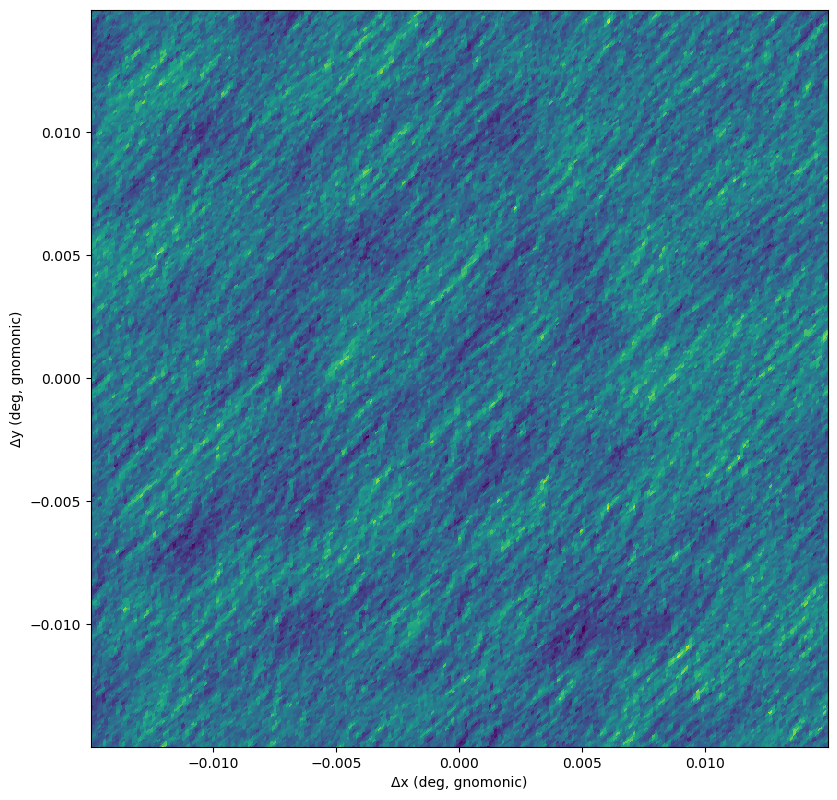

In [16]:
#To JM, the default of this plot should plot all the rgion may be??

import healpy as hp
plt.figure(figsize=(16,8))
lgnomproject(ds_plot.cell_ids,ds_plot,2**ds_plot.cell_ids.attrs['level'],fov_deg=0.03,hold=False,sub=(1,2,1))
#plt.subplot(1,2,2)
#plt.imshow(ds_plot.values)